# Librerías

In [ ]:
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import sys
import time
import numpy as np
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sage_model import GraphSAGE
from torch_geometric.loader import DataLoader
from dataset_utils import generate_edge_index, build_graph_list, build_graph_from_sample
from train_eval import train, evaluate, EarlyStopping

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [3]:
dir_path = os.getcwd()
print(dir_path)

c:\Users\ramse\Escritorio\Aero Ordenador\4to Aero\2do Cuatri\ia_thermal\ernestoemedina\SAGE_MK1


In [4]:
# Ruta del dataset completo
dataset_path = os.path.join(dir_path, "Datasets", "PCB_dataset.pth")
norm_dataset_path = os.path.join(dir_path, "Datasets", "PCB_Dataset_Norm.pth")
info_path = os.path.join(dir_path, "Datasets", "normalization_info.pth")

# Cargar dataset
dataset = torch.load(dataset_path)
norm_dataset = torch.load(norm_dataset_path)
norm_info = torch.load(info_path)

C:\Users\ramse\AppData\Local\Temp\ipykernel_20684\1864307277.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(dataset_path)
C:\Users\ramse\AppData\Lo

## Para desnormalizar

In [5]:
max_T_interfaces = norm_info["max_T_interfaces"]
max_Q_heaters = norm_info["max_Q_heaters"]
max_T_env = norm_info["max_T_env"]

## En ppio no debería ser necesario, ya que hemos cargado el dataset sin normalizar

def desnormalize_inputs(dataset_norm, idx):
    T_interfaces_norm = dataset_norm.T_interfaces[idx]
    Q_heaters_norm = dataset_norm.Q_heaters[idx]
    T_env_norm = dataset_norm.T_env[idx]
    
    T_interfaces_real = T_interfaces_norm * max_T_interfaces
    Q_heaters_real = Q_heaters_norm * max_Q_heaters
    T_env_real = T_env_norm * max_T_env
    
    return T_interfaces_real, Q_heaters_real, T_env_real

In [6]:
idx = 1
T_interfaces_real, Q_heaters_real, T_env_real = desnormalize_inputs(norm_dataset, idx)

# Por ejemplo:
print(torch.max(T_interfaces_real), "K")
print(torch.max(Q_heaters_real), "W")
print(torch.max(T_env_real), "K")


tensor(309.7728) K
tensor(0.8122) W
tensor(298.0007) K


In [7]:
# Seleccionar un índice para graficar
idx = 1  # Puedes cambiar este valor

# Obtener los valores reales de las CC en T, Q y T_env
T_interfaces_real = dataset.denormalize_T_interfaces(dataset.T_interfaces)
Q_heaters_real = dataset.denormalize_Q_heaters(dataset.Q_heaters)
T_env_real = dataset.denormalize_T_env(dataset.T_env)

print(T_interfaces_real.shape)
print(torch.max(T_interfaces_real[idx]), "K")
print(torch.max(Q_heaters_real[idx]), "W")
print(torch.max(T_env_real[idx]), "K")


torch.Size([10000, 13, 13])
tensor(309.7728) K
tensor(0.8122) W
tensor(298.0007) K


In [8]:
idx = 10
T_interfaces_norm = norm_dataset.T_interfaces[idx]
Q_heaters_norm = norm_dataset.Q_heaters[idx]
T_env_norm = norm_dataset.T_env[idx]

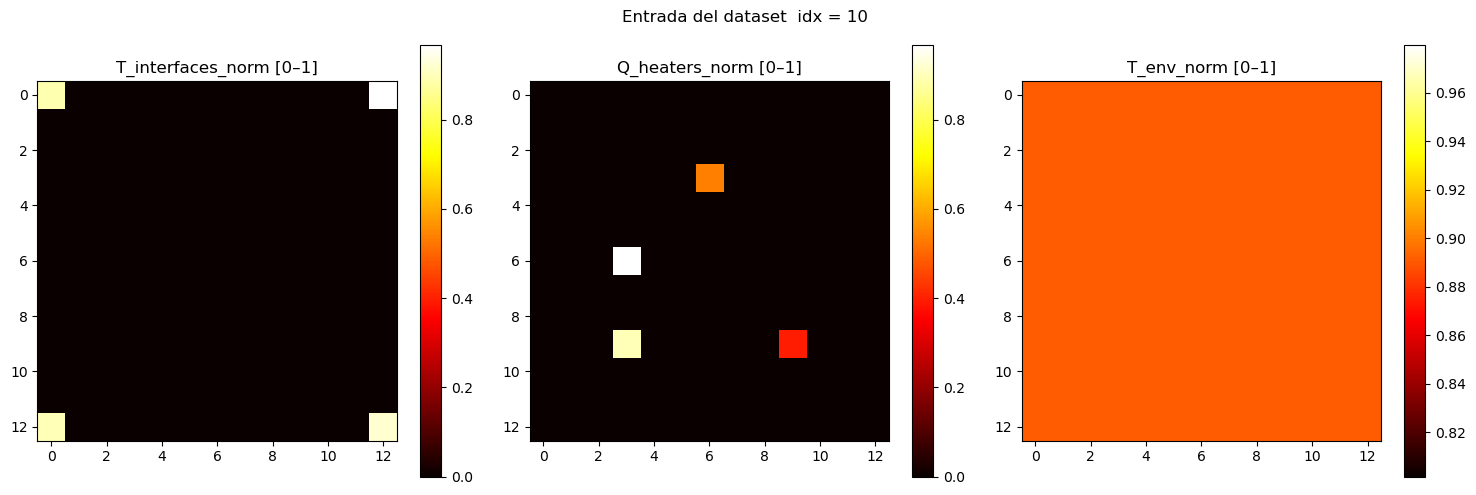

In [9]:
# Crear figura para mostrar las 3 variables
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
im1 = axs[0].imshow(T_interfaces_norm.numpy(), cmap='hot')
axs[0].set_title("T_interfaces_norm [0–1]")
plt.colorbar(im1, ax=axs[0])

im2 = axs[1].imshow(Q_heaters_norm.numpy(), cmap='hot')
axs[1].set_title("Q_heaters_norm [0–1]")
plt.colorbar(im2, ax=axs[1])

im3 = axs[2].imshow(T_env_norm.numpy(), cmap='hot')
axs[2].set_title("T_env_norm [0–1]")
plt.colorbar(im3, ax=axs[2])

plt.suptitle(f"Entrada del dataset  idx = {idx}")
plt.tight_layout()
plt.show()

## SAGE

### Configuración de la red

In [10]:
# Configuración del modelo
config = {
    "input_dim": 3,           # 3 canales: T_interfaces, Q_heaters, T_env
    "hidden_dim": 32,
    "output_dim": 1,
    "num_layers": 6,
    "use_dropout": True,
    "dropout_rate": 0.024808577242290835,
    "use_batchnorm": True,
    "use_residual": True,
    "batch_size": 32,
    "lr": 0.0020561002812769457,
    "max_epochs": 10000,
    "early_stop_patience": 100,
    "error_threshold_K": 3.0,
    "use_percentage_threshold": False,
    "percentage_threshold": 1.0,  # solo si se activa la opción
    "save_model": True,
    "load_model": False, # Cargar un modelo preentrenado
    "factor" : 0.5 , # Factor de reducción del learning rate
    "patience" : 10 , # Épocas sin mejora para reducir el learning rate
    "min_lr" : 1e-9,  # evita que baje infinitamente el learning rate
    "use_physics" : True,
    "lambda_physics" : 0.0001, # Peso de la física en la función de pérdida
    "use_boundary_loss" : True,
    "lambda_boundary" : 0.001,
    "use_heater_loss" : True,
    "lambda_heater" : 0.01
}

In [11]:
grid_size = norm_dataset.inputs.shape[-1]
print("PCB cuadrada de", grid_size, "nodos por lado")
edge_index = generate_edge_index(grid_size=grid_size) # Matriz de adyacencia bidireccional
graphs = build_graph_list(norm_dataset, edge_index)

PCB cuadrada de 13 nodos por lado


In [12]:
# Por si en algún momento el Dataset tuviera un patrón al ser generado
random.seed(42)
random.shuffle(graphs)

In [13]:

# Ruta al dataset normalizado

# Extraer un tensor de salida
sample_output = norm_dataset.outputs[0]

# Imprimir estadísticas globales de outputs
all_outputs = norm_dataset.outputs.view(-1)
print(f"Mean of outputs: {all_outputs.mean().item():.4f}")
print(f"Std of outputs:  {all_outputs.std().item():.4f}")

# También desde los atributos si están disponibles
if hasattr(norm_dataset, "T_outputs_mean"):
    print(f"Atributo .T_outputs_mean: {norm_dataset.T_outputs_mean.item():.4f}")
    print(f"Atributo .T_outputs_std:  {norm_dataset.T_outputs_std.item():.4f}")


Mean of outputs: 0.8303
Std of outputs:  0.0338
Atributo .T_outputs_mean: 0.0000
Atributo .T_outputs_std:  1.0000


### División Dataset

In [14]:
# División del dataset
train_size = int(0.8 * len(graphs))
val_size = int(0.1 * len(graphs))
test_size = len(graphs) - train_size - val_size

train_dataset = graphs[:train_size]
val_dataset = graphs[train_size:train_size + val_size]
test_dataset = graphs[train_size + val_size:]

# Crear DataLoaders
batch_size = config["batch_size"]
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
model = GraphSAGE(
    input_dim=config["input_dim"],
    hidden_dim=config["hidden_dim"],
    output_dim=config["output_dim"],
    num_layers=config["num_layers"],
    use_dropout=config["use_dropout"],
    dropout_rate=config["dropout_rate"],
    use_batchnorm=config["use_batchnorm"],
    use_residual=config["use_residual"]
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',            # queremos minimizar el val_loss
    factor=config["factor"],            # reduce a la mitad el LR
    patience=config["patience"],           # espera 10 épocas sin mejora
    verbose=True,          # imprime info cuando reduce
    min_lr=config["min_lr"]            # evita que baje infinitamente
)

c:\Users\ramse\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [16]:
print("Forma de entrada:", norm_dataset.inputs[0].shape)
print("Forma de salida:", norm_dataset.outputs[0].shape)


Forma de entrada: torch.Size([3, 13, 13])
Forma de salida: torch.Size([13, 13])


### Entrenamiento

In [ ]:
# Entrenamiento
train_losses = []
val_losses = []
epoch_times = []

early_stopper = EarlyStopping(patience=config["early_stop_patience"])
max_epochs = config["max_epochs"]
best_lr=config["lr"]

print("Iniciando entrenamiento...")
for epoch in range(config["max_epochs"]):
    start_time = time.time()
    
    # Entrenar
    train_loss = train(model, train_loader, optimizer, device, norm_info, lambda_physics=config["lambda_physics"],
                       use_physics=config["use_physics"], lambda_boundary=config["lambda_boundary"],
                       use_boundary_loss=config["use_boundary_loss"], lambda_heater=config["lambda_heater"],
                       use_heater_loss=config["use_heater_loss"])
    train_losses.append(train_loss)

    # Evaluar en validación
    val_mse, val_mae, val_r2, val_accuracy, val_physics, val_boundary, val_heaters, val_rmse, val_total_loss = evaluate(
        model, val_loader, device, norm_info, lambda_physics=config["lambda_physics"],
        use_physics=config["use_physics"], lambda_boundary=config["lambda_boundary"],
        use_boundary_loss=config["use_boundary_loss"], lambda_heater=config["lambda_heater"],
        use_heater_loss=config["use_heater_loss"],
        error_threshold=config["error_threshold_K"],
        percentage_threshold=config["percentage_threshold"] if config["use_percentage_threshold"] else None,
        plot_results=False
    )
    val_losses.append(val_mse)

    scheduler.step(val_mse)
    
    # Medir tiempo transcurrido
    epoch_duration = time.time() - start_time
    epoch_times.append(epoch_duration)

    # Formatear bien los losses opcionales
    physics_loss_str = f"{val_physics:.6f}" if config["use_physics"] else "N/A"
    boundary_loss_str = f"{val_boundary:.6f}" if config["use_boundary_loss"] else "N/A"
    heaters_loss_str = f"{val_heaters:.6f}" if config["use_heater_loss"] else "N/A"

    # Imprimir métricas
    print(f"Epoch {epoch + 1} - "
          f"Train Loss: {train_loss:.6f} | "
          f"Val MSE: {val_mse:.6f} | "
          f"Val MAE: {val_mae:.6f} | "
          f"Val R²: {val_r2:.4f} | "
          f"[Boundary loss] {boundary_loss_str} | "
          f"[Heaters loss] {heaters_loss_str} | "
          f"[Physics loss] {physics_loss_str} | "
          f"Val Accuracy: {val_accuracy:.2f}% | "
          f"LR: {optimizer.param_groups[0]['lr']:.9f}"
          f"Time: {epoch_duration:.2f}s")

    # Guardar el mejor modelo en memoria
    if val_total_loss < early_stopper.best_loss:
        best_model_state = model.state_dict()
        final_epoch = epoch + 1
        best_lr = optimizer.param_groups[0]['lr']  # guardar lr actual

    early_stopper(val_total_loss, epoch)
    if early_stopper.early_stop:
        print(f" Early stopping triggered at epoch {epoch}")
        avg_epoch_time = np.mean(epoch_times)
        print(f"Tiempo por época        : {avg_epoch_time:.2f}")
        break


Iniciando entrenamiento...
Epoch 1 - Train Loss: 0.018540 | Val MSE: 0.000666 | Val MAE: 0.019465 | Val R²: 0.3475 | [Boundary loss] 0.004028 | [Heaters loss] 0.000746 | [Physics loss] 1.988042 | Val Accuracy: 27.77% | LR: 0.002056100Time: 7.26s
Epoch 2 - Train Loss: 0.003571 | Val MSE: 0.000259 | Val MAE: 0.012820 | Val R²: 0.7460 | [Boundary loss] 0.002671 | [Heaters loss] 0.000316 | [Physics loss] 1.719650 | Val Accuracy: 39.12% | LR: 0.002056100Time: 6.90s
Epoch 3 - Train Loss: 0.002080 | Val MSE: 0.000252 | Val MAE: 0.012138 | Val R²: 0.7534 | [Boundary loss] 0.003087 | [Heaters loss] 0.000319 | [Physics loss] 1.650514 | Val Accuracy: 42.08% | LR: 0.002056100Time: 6.77s
Epoch 4 - Train Loss: 0.001526 | Val MSE: 0.000354 | Val MAE: 0.015208 | Val R²: 0.6527 | [Boundary loss] 0.000780 | [Heaters loss] 0.000365 | [Physics loss] 1.589520 | Val Accuracy: 32.53% | LR: 0.002056100Time: 6.91s
Epoch 5 - Train Loss: 0.001232 | Val MSE: 0.000154 | Val MAE: 0.010015 | Val R²: 0.8497 | [Bounda

KeyboardInterrupt: 

In [ ]:
# Cargar el mejor modelo antes de guardar
if best_model_state is not None:
    model.load_state_dict(best_model_state)
else:
    print("Advertencia: No se ha encontrado un modelo mejor durante el entrenamiento.")

# Crear nombre de archivo con los hiperparámetros clave
model_name = (
    f"SAGE_Layers_{config['num_layers']}_"
    f"HDim_{config['hidden_dim']}_"
    f"Epochs_{final_epoch}_"
    f"Lr_{best_lr:.9f}_"
    f"B_LOSS_{config['use_boundary_loss']}_"
    f"Lambda_{config['lambda_boundary']}_"
    f"H_LOSS_{config['use_heater_loss']}_"
    f"Lambda_{config['lambda_heater']}_"
    f"PI_{config['use_physics']}_"
    f"Lambda_{config['lambda_physics']}_"
    f"Batch_{config['batch_size']}.pth"
)
print("Nombre del modelo:", model_name)

Nombre del modelo: SAGE_Layers_6_HDim_32_Epochs_116_Lr_0.000257013_B_LOSS_True_Lambda_0.001_H_LOSS_True_Lambda_0.01_PI_True_Lambda_0.0001_Batch_32.pth


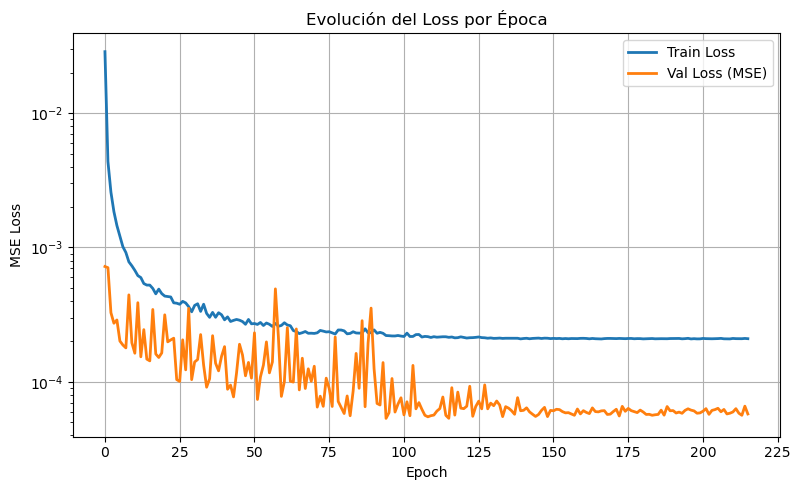

In [ ]:
# GRAFICAR MSE
# Crear carpeta si no existe
os.makedirs("LOSS_IMG", exist_ok=True)
loss_img_filename = model_name.replace(".pth", ".svg")
loss_img_path = os.path.join("LOSS_IMG", loss_img_filename)

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Val Loss (MSE)', linewidth=2)

# Escala logarítmica en y (opcional)
plt.yscale("log")

plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Evolución del Loss por Época')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Eje X con enteros
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.savefig(loss_img_path, format="svg") 
plt.show()

### Carga de modelos ya entrenados

In [ ]:
if config["load_model"]:
    from dataset_utils import load_model_by_name


    # Definir el modelo a cargar, los modelos guardados no guardan la arquitectura de la red
    model = GraphSAGE(
        input_dim=config["input_dim"],
        hidden_dim= 64,
        output_dim=config["output_dim"],
        num_layers= 10,
        use_dropout=config["use_dropout"],
        dropout_rate=config["dropout_rate"],
        use_batchnorm=config["use_batchnorm"],
        use_residual=config["use_residual"]
    ).to(device)

    # Nombre exacto del archivo que quieres cargar, cambiar solo los números
    model_filename = "SAGE_Layers_5_HDim_128_Epochs_93_Lr_0.000277063_B_LOSS_True_Lambda_0.001_H_LOSS_True_Lambda_0.01_PI_True_Lambda_0.0001_Batch_16.pth"

    # Cargar modelo concreto
    model = load_model_by_name(model, model_filename)
    print("Modelo cargado:", model_filename)


### Evaluación

Evaluando en test set con visualización de un ejemplo:


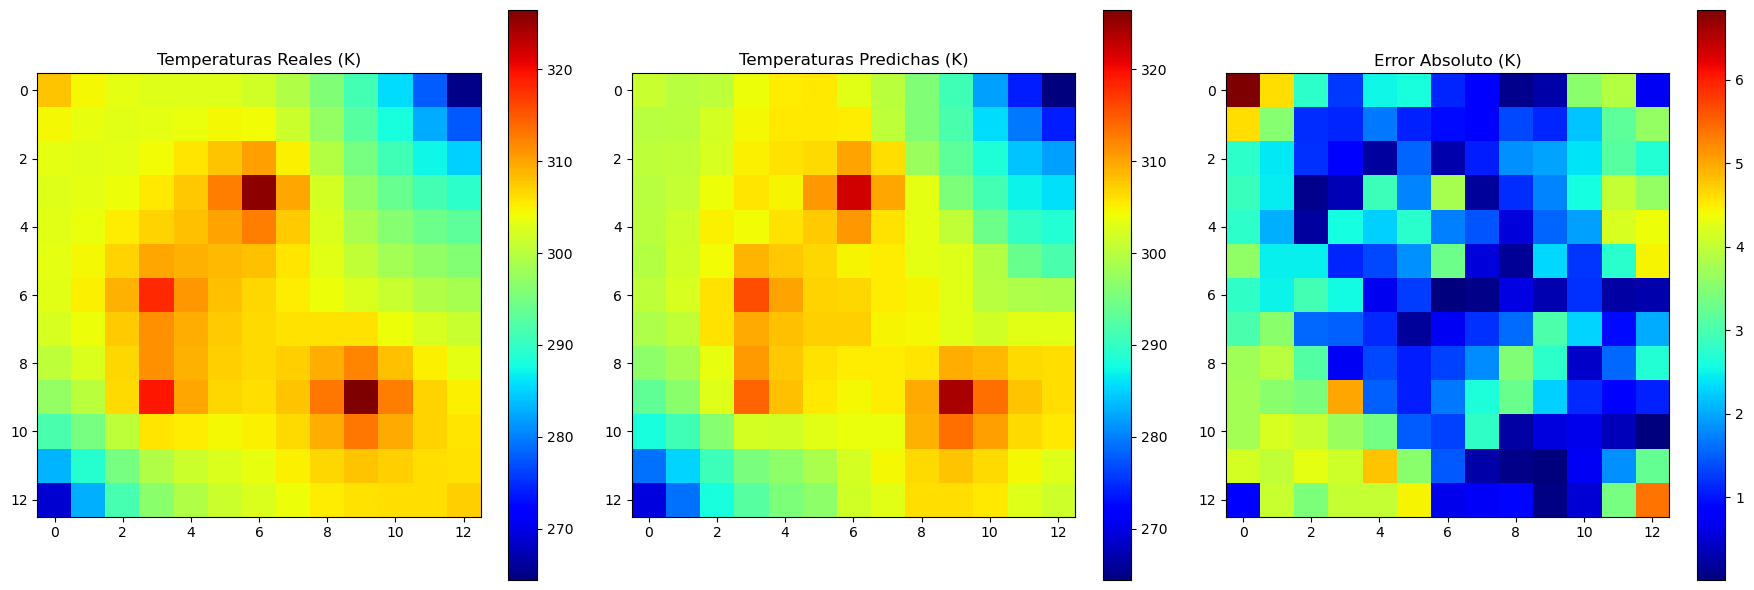

MAE en Kelvin     : 2.204 K
RMSE en Kelvin    : 2.749 K
MSE en Kelvin²    : 7.555 K²
Resultados del test:
MSE       : 0.000057
MAE       : 0.006048
R²        : 0.9421
Accuracy  : 72.30%
Boundary Loss  : 0.000117
Heaters Loss  : 0.000058
Physics Loss  : 1.485472


In [ ]:
# Evaluar en test y graficar un ejemplo
print("Evaluando en test set con visualización de un ejemplo:")
test_mse, test_mae, test_r2, test_accuracy, test_physics, test_boundary, test_heater, test_rmse, test_total_loss = evaluate(
    model, test_loader, device, norm_info, lambda_physics=config["lambda_physics"],
    use_physics=config["use_physics"], lambda_boundary=config["lambda_boundary"],
    use_boundary_loss=config["use_boundary_loss"], lambda_heater=config["lambda_heater"],
    use_heater_loss=config["use_heater_loss"],
    error_threshold=config["error_threshold_K"],
    percentage_threshold=config["percentage_threshold"] if config["use_percentage_threshold"] else None,
    plot_results=True
)

physics_loss_str = f"{test_physics:.6f}" if test_physics is not None else "N/A"

max_T_outputs = norm_info["max_T_outputs"].to(device)
mae_K = test_mae * max_T_outputs
rmse_K = test_rmse * (max_T_outputs)
mse_K = test_mse * (max_T_outputs ** 2)
print(f"MAE en Kelvin     : {mae_K:.3f} K")
print(f"RMSE en Kelvin    : {rmse_K:.3f} K")
print(f"MSE en Kelvin²    : {mse_K:.3f} K²")

print("Resultados del test:")
print(f"MSE       : {test_mse:.6f}")
print(f"MAE       : {test_mae:.6f}")
print(f"R²        : {test_r2:.4f}")
print(f"Accuracy  : {test_accuracy:.2f}%")
print(f"Boundary Loss  : {test_boundary:.6f}")
print(f"Heaters Loss  : {test_heater:.6f}")
print(f"Physics Loss  : {physics_loss_str}")

### GNNExplainer

Número de nodos: 169


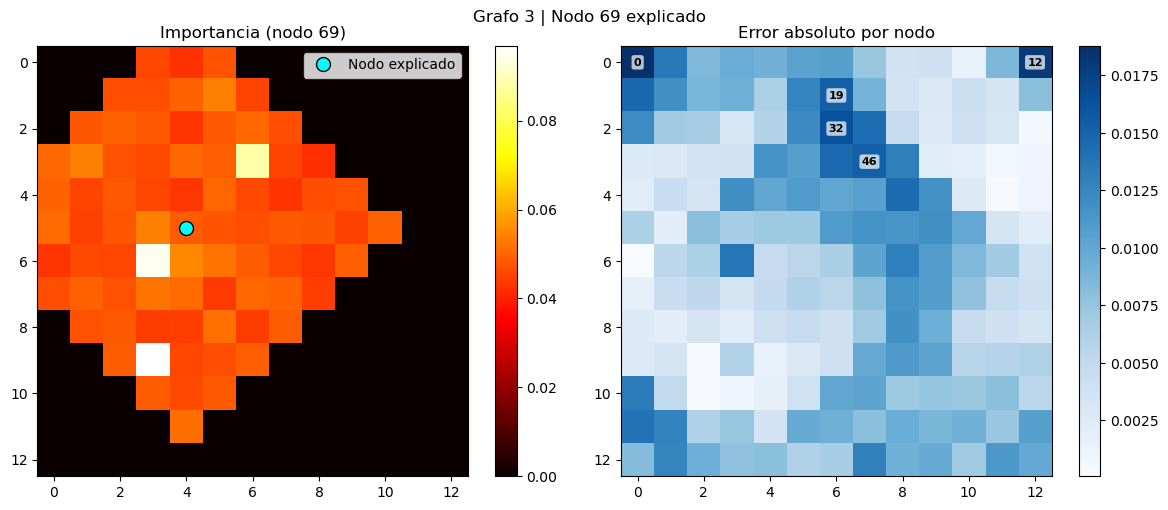

In [ ]:
from torch_geometric.explain import Explainer, GNNExplainer, ModelConfig

# Poner el modelo en modo evaluación
model.eval()

# Crear el explainer solo una vez
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    edge_mask_type='object',
    node_mask_type='attributes',
    model_config=ModelConfig(
        mode='regression',
        task_level='node',
        return_type='raw'
    )
)

# ---------------- CONFIGURACIÓN ----------------
graph_idx = 3      # <- Cambia este valor para elegir el grafo del test set
node_idx = 69     # <- Cambia este valor para elegir el nodo a explicar
# ------------------------------------------------

# Obtener el grafo y pasarlo a GPU si es necesario
graph = test_dataset[graph_idx].to(device)

# Predecir con el modelo
with torch.no_grad():
    pred = model(graph.x, graph.edge_index).squeeze()
true = graph.y.squeeze()
error = torch.abs(pred - true)

# Obtener explicación
explanation = explainer(
    x=graph.x,
    edge_index=graph.edge_index,
    index=node_idx
)

# Obtener importancia del explainer y agrupar por nodo
importance = explanation.node_mask.squeeze().cpu()      # Así obtenemos las features por nodo
importance = importance.view(-1, 3)                     # Cambiamos a un tensor que pueda ser interpretado como [num_nodes, num_features]
importance_per_node = importance.mean(dim=1)            # [num_nodes] Hacemos la media de la importancia de las 3 características en la predicción

# Obtener tamaño cuadrícula real del dataset
num_nodes = graph.y.numel()
print("Número de nodos:", num_nodes)
grid_size = int(num_nodes ** 0.5)
assert grid_size ** 2 == num_nodes, f"El número de nodos ({num_nodes}) no coincide con cuadrícula {grid_size}x{grid_size}"

# Convertir vectores a cuadrícula
importance_grid = importance_per_node.view(grid_size, grid_size)
error_grid = error.view(grid_size, grid_size).cpu()

# Visualización
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

im1 = axs[0].imshow(importance_grid, cmap='hot')
# Coordenadas del nodo que estás explicando
row = node_idx // grid_size
col = node_idx % grid_size

# Dibujar un punto rojo en la celda correspondiente
axs[0].plot(col, row, 'o', markersize=10, markeredgecolor='black', markerfacecolor='cyan', label='Nodo explicado')
axs[0].legend(loc='upper right')

axs[0].set_title(f"Importancia (nodo {node_idx})")
plt.colorbar(im1, ax=axs[0])

im2 = axs[1].imshow(error_grid, cmap='Blues')
# Número de nodos a etiquetar
top_n = 5  # "n" nodos de mayor error a mostrar

# Obtener los índices de los nodos con mayor error
top_error_nodes = torch.topk(error, top_n).indices.cpu()

for idx in top_error_nodes:
    idx = idx.item()
    row = idx // grid_size
    col = idx % grid_size
    axs[1].text(
        col, row, str(idx),
        ha='center', va='center',
        fontsize=8, fontweight='bold',
        color='black', bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none', alpha=0.7)
    )
axs[1].set_title("Error absoluto por nodo")
plt.colorbar(im2, ax=axs[1])

plt.suptitle(f"Grafo {graph_idx} | Nodo {node_idx} explicado")
plt.tight_layout()
plt.show()

### Guardado del modelo ya entrenado

In [ ]:
# Crear carpeta si no existe
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

# Guardar el modelo
model_path = os.path.join(save_dir, model_name)
if config["save_model"]:
    # Guardar el modelo entrenado
    torch.save(model.state_dict(), model_path)

    print(f" Modelo guardado en: {model_path}")

 Modelo guardado en: saved_models\SAGE_Layers_6_HDim_32_Epochs_116_Lr_0.000257013_B_LOSS_True_Lambda_0.001_H_LOSS_True_Lambda_0.01_PI_True_Lambda_0.0001_Batch_32.pth


### Predicción

In [ ]:

fr train_eval import predict
from dataset_utils import load_latest_model
# Cargar el modelo más reciente
model = GraphSAGE(
    input_dim=config["input_dim"],
    hidden_dim=config["hidden_dim"],
    output_dim=config["output_dim"],
    num_layers=config["num_layers"],
    use_dropout=config["use_dropout"],
    dropout_rate=config["dropout_rate"],
    use_batchnorm=config["use_batchnorm"],
    use_residual=config["use_residual"]
)

model = load_latest_model(model)

# Predecir sobre test
predicciones = predict(model, test_loader)

print("Predicciones shape:", predicciones.shape)

SyntaxError: invalid syntax (657155860.py, line 1)